<a href="https://colab.research.google.com/github/niquibonnet/Mon-reve---webscraping/blob/main/webscraping_bonnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mon rêve - Projet de WebScrping

In [267]:
#Importation des différentes librairies
import pandas as pd
import bs4
from bs4 import BeautifulSoup
import requests
import csv

In [268]:
print('pandas version: {}'.format(pd.__version__))
print('bs4 version: {}'.format(bs4.__version__))
print('requests version: {}'.format(requests.__version__))
print('csv version: {}'.format(csv.__version__))

pandas version: 1.3.5
bs4 version: 4.6.3
requests version: 2.25.1
csv version: 1.0


In [269]:
#fonction pour récupérer les urls des deux sites 
def get_url(search_term, pages):
    template = 'https://www.amazon.fr/s?k=panneau+solaire+van+am%C3%A9nag%C3%A9&crid=NB6GNAHTS5J6&sprefix=%2Caps%2C158&ref=nb_sb_ss_recent_3_0_recent'
    template2 = 'https://allo.solar/panneaux-solaires-photovoltaique.html'
    urls= []
    
    for i in range(2,pages):
        search_term= search_term.replace(' ','+')
        url= template.format(search_term, i)
        url2= template2.format(search_term, i)
        urls.append(url)
    return urls

In [270]:
#Récupérer les différentes critères dont nous avons besoin
def scrape_record(item):
    atag= item.h2.a
    description= atag.text.strip()
    
    #Prix
    try:
        price_parent= item.find('span','a-price')
        price= price_parent.find('span', 'a-offscreen').text
    except AttributeError:
        return
    
    #Note
    try:
        rating= item.i.text.strip()[:3]
    except AttributeError:
        rating= 'None'
        
    #Nombre d'avis    
    try:
        review_count= item.find('span',{'class': 'a-size-base s-underline-text'}).text
    except AttributeError:
        review_count= 'None'
    
    record= (description, price, rating, review_count)
    
    return record

In [271]:
#on ne récupère pas que les données de la première page mais aussi des pages suivantes
def scrape_all_pages(urls):
    records= [] 
    
    for url in urls:
        headers= {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36", "Accept-Encoding":"gzip, deflate", "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", "DNT":"1","Connection":"close", "Upgrade-Insecure-Requests":"1"}
        page= requests.get(url, headers=headers) 
        soup= BeautifulSoup(page.content,'html.parser')

        results= soup.find_all('div',{'data-component-type':'s-search-result'})
        
        for item in results:
            record= scrape_record(item)
            if record:
                records.append(record)
                
    # On écrit dans un csv 
    
    with open("data.csv", 'w', newline='', encoding='utf-8') as f:
        writer= csv.writer(f)
        writer.writerow(['Description', 'Prix', 'Note/5', "Nombre d'avis"])
        writer.writerows(records)
    return records

In [272]:
urls= get_url('panneaux solaires van aménagé',75)
records= scrape_all_pages(urls)

In [273]:
df= pd.read_csv('data.csv')

In [274]:
pd.set_option('display.max_rows', None)
df.head()
df.count()

Description      3588
Prix             3588
Note/5           3581
Nombre d'avis    3588
dtype: int64

In [275]:
df = df.drop_duplicates()
df.count()

Description      142
Prix             142
Note/5           140
Nombre d'avis    142
dtype: int64

In [276]:
df = df.sort_values(by='Note/5', ascending=False)
df = df[df['Note/5'] != "None"]
df = df[df["Nombre d'avis"] != "None"]
df.head()

,Description,Prix,Note/5,Nombre d'avis
184,XINPUGUANG Kit de Panneau Solaire 300w 12v: mo...,"188,99 €","5,0",(1)
32,XINPUGUANG Kit de Panneau Solaire 300w 12v: mo...,"188,99 €","5,0",1
1821,ECOFLOW Générateur Solaire DELTA Max 2016Wh av...,"3 789,00 €","4,8",(15)
875,ECOFLOW Générateur Solaire DELTA Max 2016Wh av...,"3 789,00 €","4,8",15
1562,Pack Générateur Solaire EcoFlow DELTA 2 et pan...,"1 798,00 €","4,8",(41)


In [277]:
import re
df["Nombre d'avis"] = df["Nombre d'avis"].apply(lambda x: re.sub(r'^[^\d]+', '', x))
df["Nombre d'avis"] = df["Nombre d'avis"].apply(lambda x: re.sub(r'[^\d]+$', '', x))
df["Nombre d'avis"] = df["Nombre d'avis"].apply(lambda x: re.sub(r'[^a-zA-Z0-9]', '', x))

In [278]:
df["Nombre d'avis"] = df["Nombre d'avis"].astype(float)

In [279]:
df = df.sort_values(by="Nombre d'avis", ascending=True)
df = df.drop_duplicates()
df.head()

,Description,Prix,Note/5,Nombre d'avis
184,XINPUGUANG Kit de Panneau Solaire 300w 12v: mo...,"188,99 €","5,0",1.0
166,"HCKZ Panneau Solaire 100 W, Panneau Solaire Ha...","55,00 €","1,0",1.0
2014,Robinet Électrique Сhauffe-Eau Instantané 230 ...,"44,99 €","1,0",1.0
128,LZH FILTER Panneaux Solaires Polycristallins 2...,"74,00 €","3,0",2.0
1511,Micvtve Jeu de Panneau Solaire 30W Chargeur de...,"102,81 €","1,4",3.0


In [280]:
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
liste_description=[]
for row in df['Description']:
  liste_description.append(str(row))
  
avis = ' '.join(liste_description).lower()
lemmatizer = WordNetLemmatizer()

In [281]:
nltk.download('stopwords')
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np

from wordcloud import WordCloud, ImageColorGenerator

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


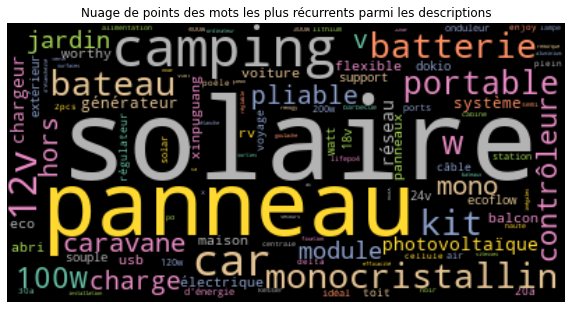

In [282]:
stopwords_list=stopwords.words('french')
stopwords_list2=list(np.append(stopwords_list,['plu','très','a','alor','toujour',"c'est",'quand','alor','fait',"j'ai",'plus','depui','cette','si','depuis','tout','sans']))

wordcloud = WordCloud(stopwords = stopwords_list2, background_color='black', colormap='Set2',
                      collocations=False).generate(avis)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.title("Nuage de points des mots les plus récurrents parmi les descriptions")
plt.show()

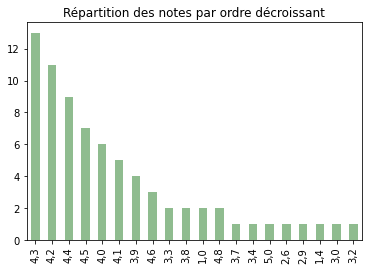

In [283]:
df['Note/5'].value_counts().plot(kind='bar', color = 'darkseagreen')
plt.title("Répartition des notes par ordre décroissant")
plt.show()

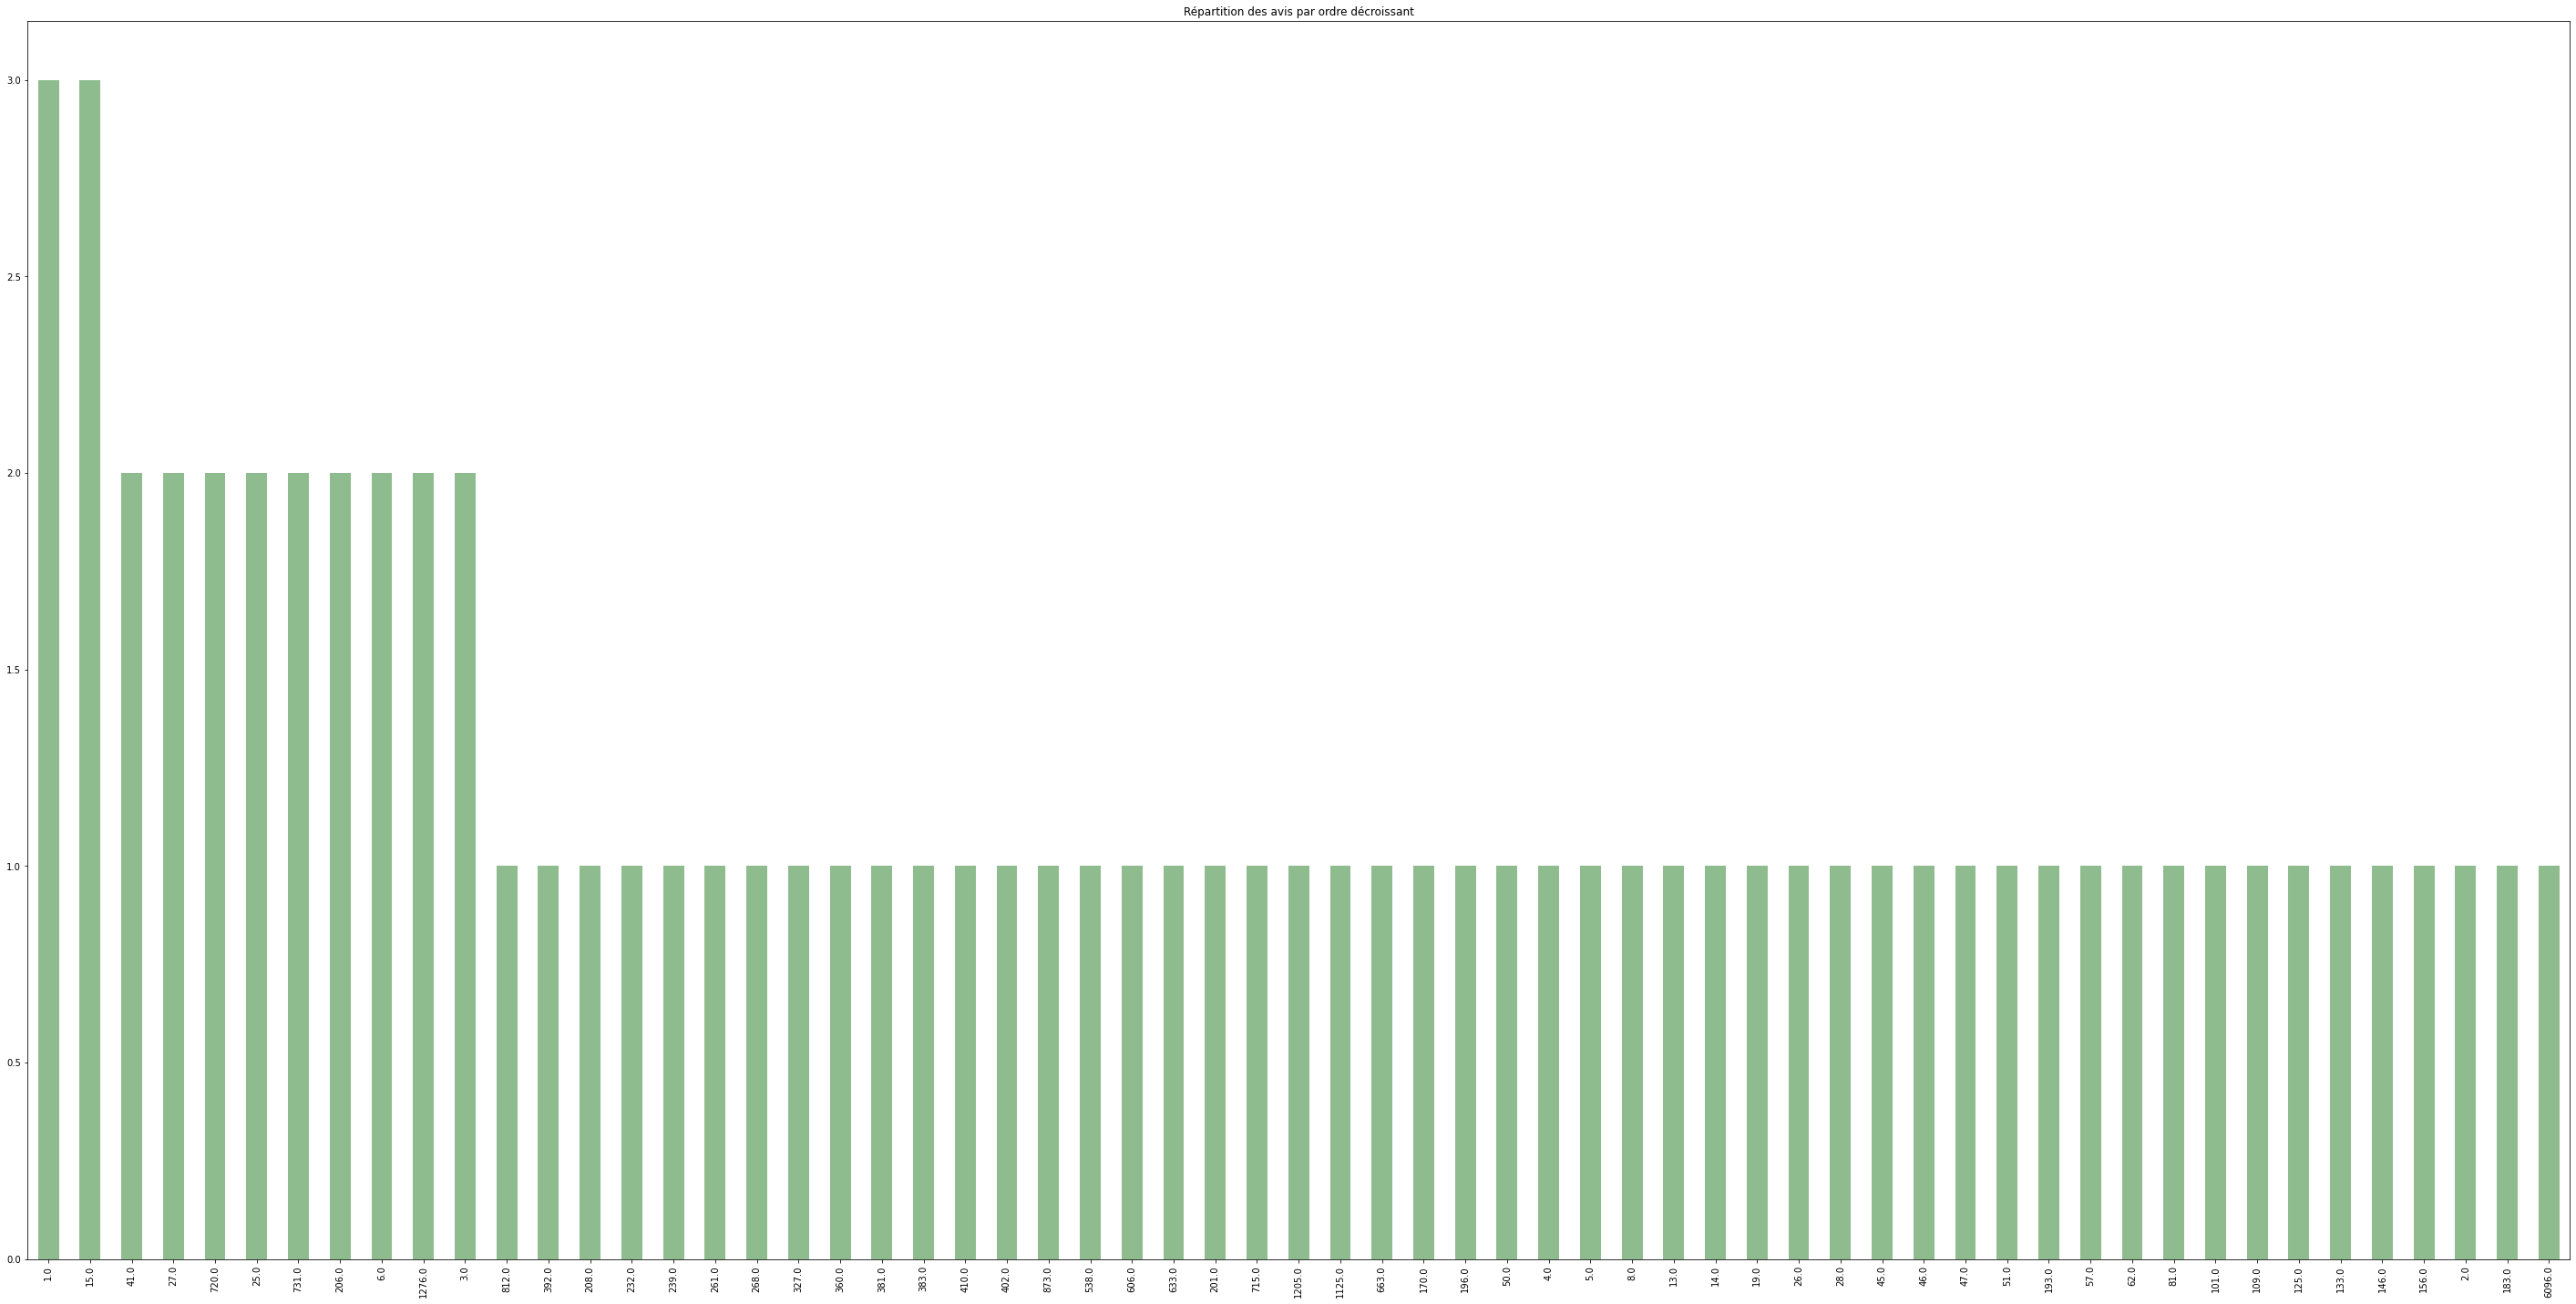

In [284]:
df["Nombre d'avis"].value_counts().plot(kind='bar', color = 'darkseagreen')
plt.title("Répartition des avis par ordre décroissant")
plt.gcf().set_size_inches(50, 25)
plt.show()

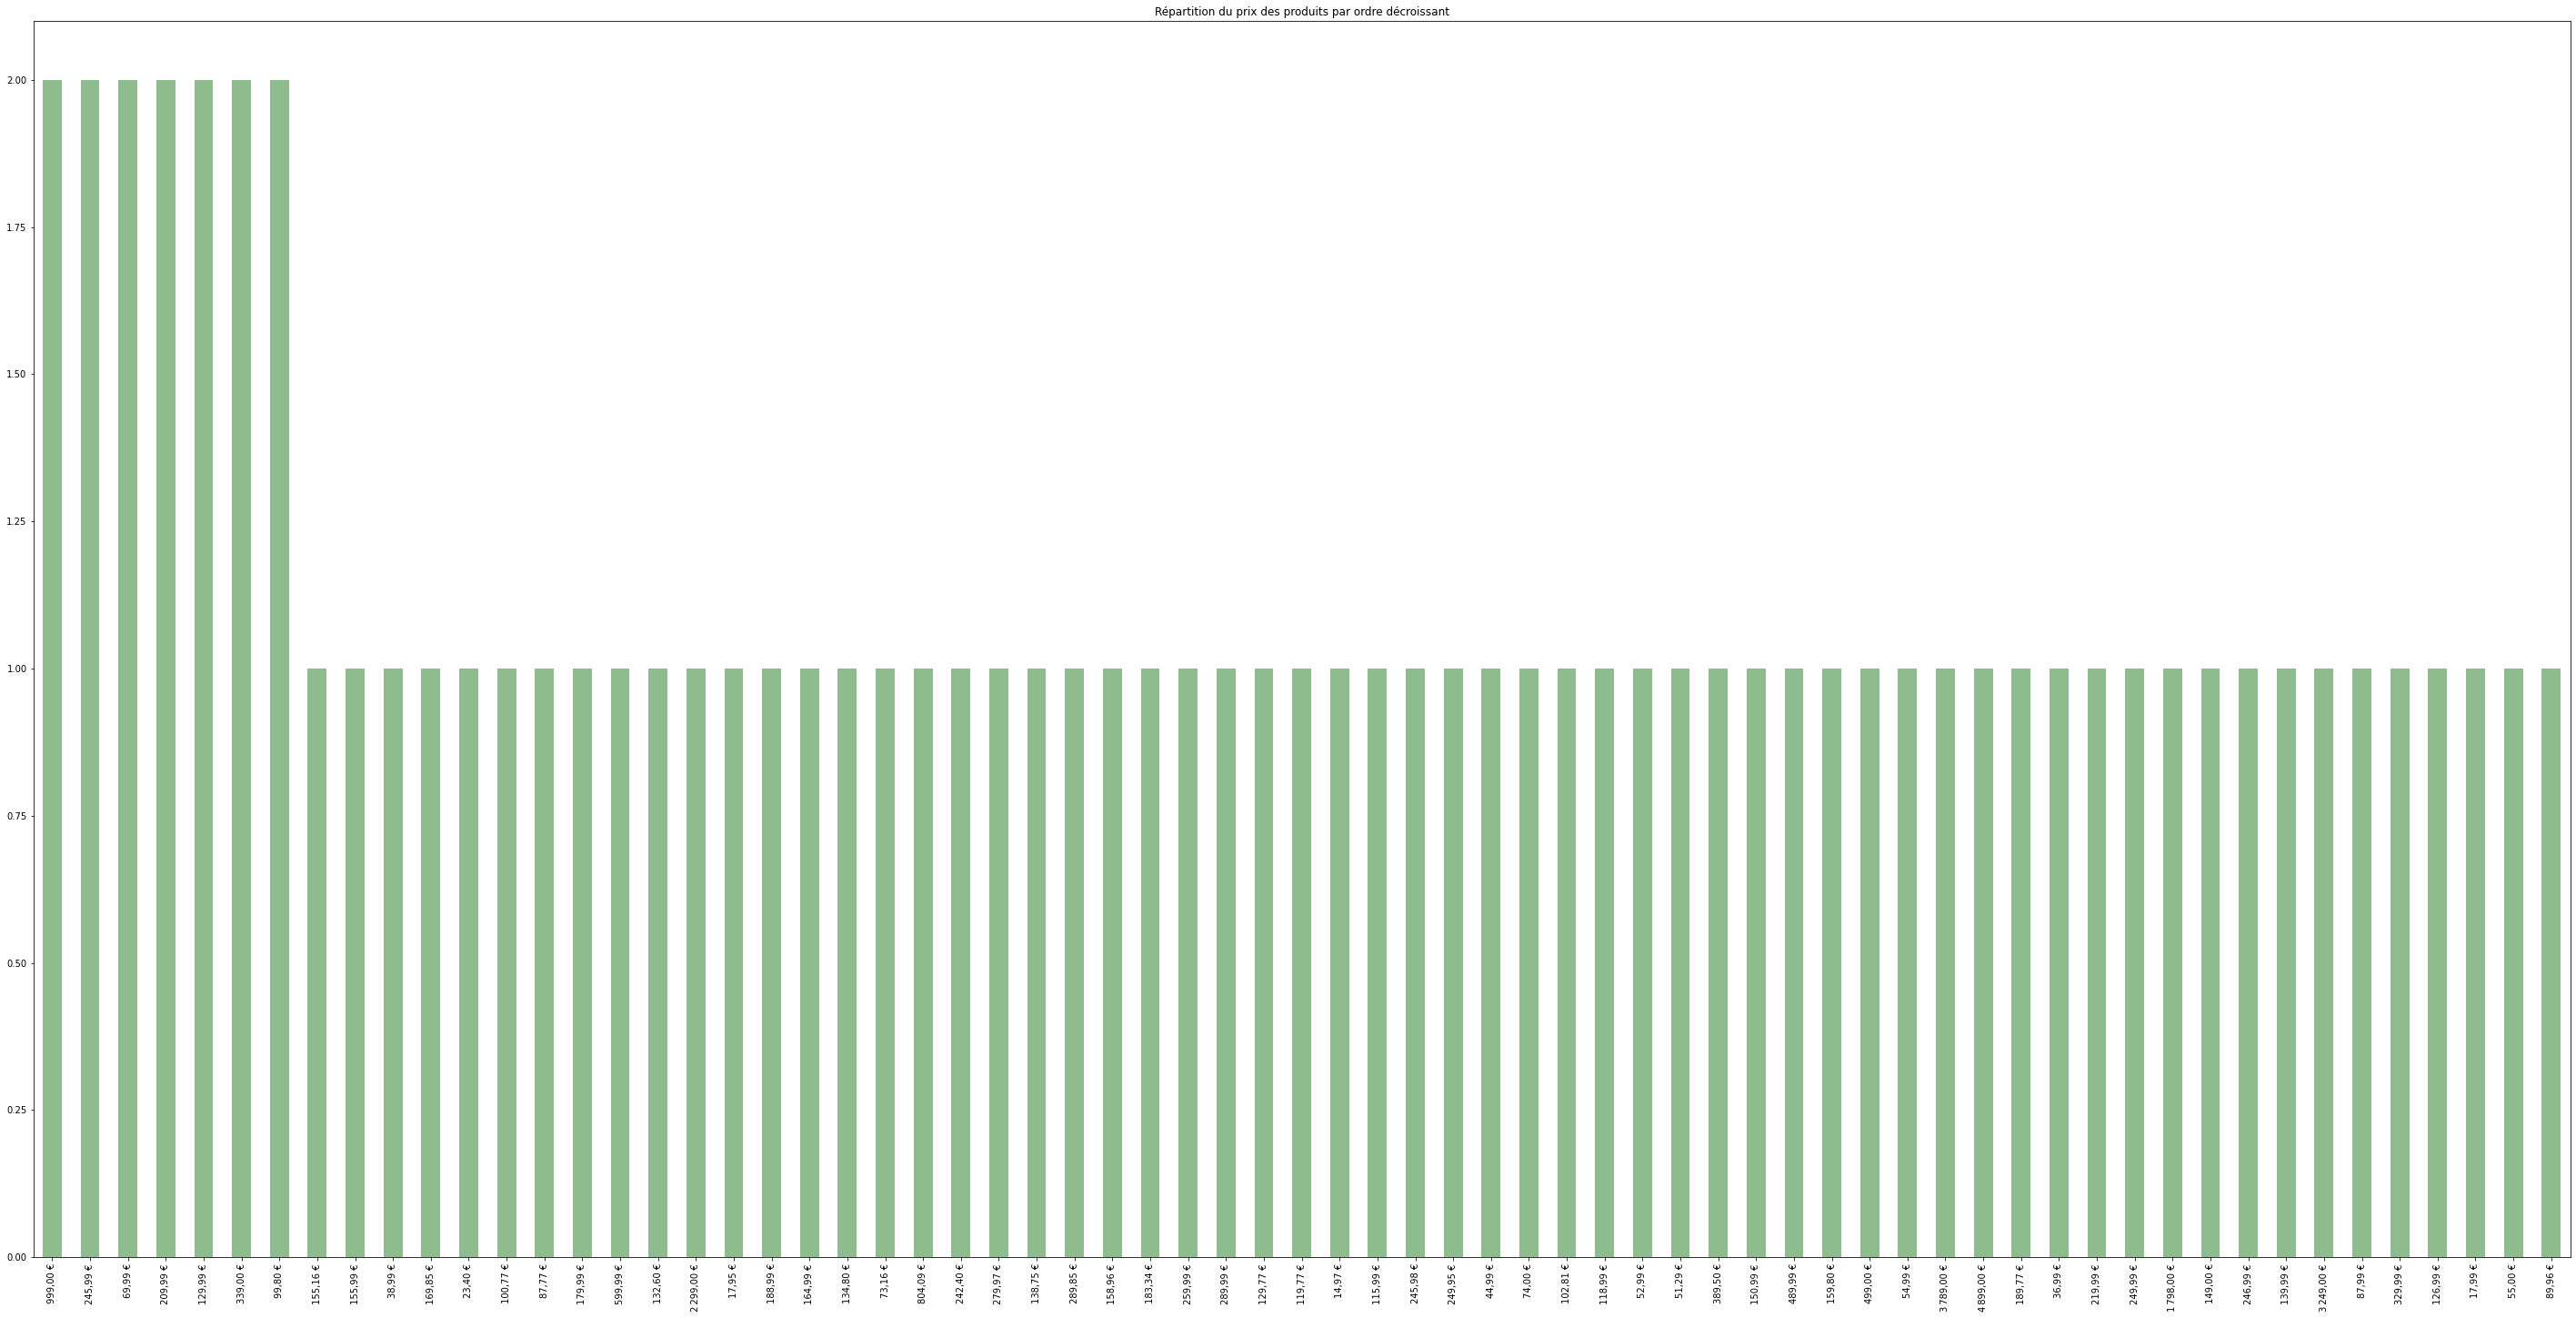

In [285]:
df["Prix"].value_counts().plot(kind='bar', color = 'darkseagreen')
plt.title("Répartition du prix des produits par ordre décroissant")
plt.gcf().set_size_inches(50, 25)
plt.show()

In [286]:
df = df[df["Note/5"] > "4,0"]
df.head()

,Description,Prix,Note/5,Nombre d'avis
184,XINPUGUANG Kit de Panneau Solaire 300w 12v: mo...,"188,99 €","5,0",1.0
1592,"Aluminium panneau solaire support 70cm, suppor...","52,99 €","4,2",4.0
146,SWAREY Générateur Solaire Portable S240 240Wh/...,"389,50 €","4,6",6.0
1510,Nicesolar Panneau Solaire Portable 200 W kit d...,"499,00 €","4,3",14.0
875,ECOFLOW Générateur Solaire DELTA Max 2016Wh av...,"3 789,00 €","4,8",15.0


In [287]:
df = df[df["Nombre d'avis"] > 100]
df.count()
df.head()

,Description,Prix,Note/5,Nombre d'avis
153,XINPUGUANG 200 W Kit 2 pcs 100 Watt 18 V Panne...,"115,99 €","4,2",109.0
39,DOKIO Panneau solaire pliable 150 W avec régul...,"189,77 €","4,2",125.0
10,"CTECHi Générateur Solaire Portable 240Wh, Géné...","245,98 €","4,4",133.0
1616,KESSER® Panneau solaire monocristallin Panneau...,"134,80 €","4,3",146.0
36,Enjoy solar Mono 5 W 12V Panneau solaire monoc...,"17,95 €","4,3",170.0


In [288]:
df["Prix"] = df["Prix"].apply(lambda x: re.sub(r'[^\d]+$', '', x))
df

,Description,Prix,Note/5,Nombre d'avis
153,XINPUGUANG 200 W Kit 2 pcs 100 Watt 18 V Panne...,"115,99","4,2",109.0
39,DOKIO Panneau solaire pliable 150 W avec régul...,"189,77","4,2",125.0
10,"CTECHi Générateur Solaire Portable 240Wh, Géné...","245,98","4,4",133.0
1616,KESSER® Panneau solaire monocristallin Panneau...,"134,80","4,3",146.0
36,Enjoy solar Mono 5 W 12V Panneau solaire monoc...,"17,95","4,3",170.0
148,Topsolar Panneau Solaire Flexible 100W 24V/12V...,"132,60","4,2",183.0
95,Dokio 100W-12V Panneau Solaire MONO Souple Sem...,"100,77","4,1",193.0
179,Enjoy solar Mono 10 W 12V Panneau solaire mono...,"23,40","4,1",196.0
182,Enjoy solar Mono 140 W 12V Panneau solaire mon...,"155,16","4,4",201.0
25,XINPUGUANG Kit de Panneau Solaire système hors...,"155,99","4,3",206.0


In [289]:
df["Prix"] = df["Prix"].apply(lambda x: x.replace(",", ".") if type(x) == str else x)
df.head()

,Description,Prix,Note/5,Nombre d'avis
153,XINPUGUANG 200 W Kit 2 pcs 100 Watt 18 V Panne...,115.99,"4,2",109.0
39,DOKIO Panneau solaire pliable 150 W avec régul...,189.77,"4,2",125.0
10,"CTECHi Générateur Solaire Portable 240Wh, Géné...",245.98,"4,4",133.0
1616,KESSER® Panneau solaire monocristallin Panneau...,134.80,"4,3",146.0
36,Enjoy solar Mono 5 W 12V Panneau solaire monoc...,17.95,"4,3",170.0


In [290]:
df

,Description,Prix,Note/5,Nombre d'avis
153,XINPUGUANG 200 W Kit 2 pcs 100 Watt 18 V Panne...,115.99,"4,2",109.0
39,DOKIO Panneau solaire pliable 150 W avec régul...,189.77,"4,2",125.0
10,"CTECHi Générateur Solaire Portable 240Wh, Géné...",245.98,"4,4",133.0
1616,KESSER® Panneau solaire monocristallin Panneau...,134.80,"4,3",146.0
36,Enjoy solar Mono 5 W 12V Panneau solaire monoc...,17.95,"4,3",170.0
148,Topsolar Panneau Solaire Flexible 100W 24V/12V...,132.60,"4,2",183.0
95,Dokio 100W-12V Panneau Solaire MONO Souple Sem...,100.77,"4,1",193.0
179,Enjoy solar Mono 10 W 12V Panneau solaire mono...,23.40,"4,1",196.0
182,Enjoy solar Mono 140 W 12V Panneau solaire mon...,155.16,"4,4",201.0
25,XINPUGUANG Kit de Panneau Solaire système hors...,155.99,"4,3",206.0


In [291]:
df = df[df["Description"].str.contains("12 V")]

In [292]:
df = df.drop_duplicates()
df

,Description,Prix,Note/5,Nombre d'avis
39,DOKIO Panneau solaire pliable 150 W avec régul...,189.77,"4,2",125.0
1616,KESSER® Panneau solaire monocristallin Panneau...,134.80,"4,3",146.0
158,ECO-WORTHY 130 Watt 12 Volt Panneau Solaire Mo...,164.99,"4,2",383.0
16,"Renogy Panneau Solaire 175 W, Chargeur 12 V PV...",209.99,"4,6",402.0
162,Renogy Panneau Solaire Souple 175 W 12 V Mono ...,289.99,"4,5",1205.0


In [293]:
print(df.to_markdown())

|      | Description                                                                                                                                                                                   |   Prix | Note/5   |   Nombre d'avis |
|-----:|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------:|:---------|----------------:|
|   39 | DOKIO Panneau solaire pliable 150 W avec régulateur de charge solaire (PWM, 2 ports USB) pour batteries 12 V, avec sac de transport pour camping, solaire, convient pour camping-car, bateau. | 189.77 | 4,2      |             125 |
| 1616 | KESSER® Panneau solaire monocristallin Panneau solaire - 18 V pour batteries 12 V, photovoltaïque - Cellule solaire Installation PV, 180 watts                                                | 134.8  | 4,3      |             146 |
|  158 | ECO-WORTHY 130 Watt 12 Volt Panneau